## 00. Import libraries and load data

Note: This Jupyter Notebook was created as part of the group work. Each member has contributed similarly to the result.

In [40]:
# First we import all neccessary libraries and give some of them an alias for easy access
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE
from sklearn.base import clone
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 1. Read in the data

In [41]:
# Read in the data so every group member can run the notebook on his machine
# (our repo is on github, we therefore have the same file structure)
df = pd.read_csv("./Data/Transformed/inventory_management_cleaned_transformed_unscaled.csv")
df.shape # Get a first idea about the number of rows and columns of the dataset

(1722, 10)

In [42]:
# Check the data
df.head()

,Category,Region,Inventory Level,Price,Discount,Weather Condition,Promotion,Demand,Product_UID,Weekday
0,1,1,195,72.72,5,1,0,115,S001_P0001,2
1,0,1,117,80.16,15,1,1,229,S001_P0002,2
2,0,1,247,62.94,10,1,1,157,S001_P0003,2
3,1,1,139,87.63,10,1,0,52,S001_P0004,2
4,3,1,152,54.41,0,1,0,59,S001_P0005,2


In [43]:
# We define that y equals the attribute we want to predict and X equals all the other attributes to predict y 
y = df["Promotion"]
X = df.loc[:, ~df.columns.isin(['Promotion', 'Product_UID'])]

In [44]:
# We check if y equals the attribute we want to predict (promotion)
y

0       0
1       1
2       1
3       0
4       0
       ..
1717    0
1718    1
1719    0
1720    0
1721    1
Name: Promotion, Length: 1722, dtype: int64

In [45]:
# We check if X equals all other attributes than promotion to predict this attribute 
X

,Category,Region,Inventory Level,Price,Discount,Weather Condition,Demand,Weekday
0,1,1,195,72.72,5,1,115,2
1,0,1,117,80.16,15,1,229,2
2,0,1,247,62.94,10,1,157,2
3,1,1,139,87.63,10,1,52,2
4,3,1,152,54.41,0,1,59,2
...,...,...,...,...,...,...,...,...
1717,3,1,129,62.83,10,0,143,5
1718,2,1,104,98.97,10,0,54,5
1719,2,1,494,111.25,10,0,70,5
1720,3,2,625,69.62,5,1,69,5


# 2. Split the data with Split Validation

In [46]:
# We check the imbalance of the data set to get further information for potential data augmentation techniques
y.value_counts()

Promotion
0    1097
1     625
Name: count, dtype: int64

In [47]:
# We split our Data into test and train Data so we can later train on the train data and measure the performance on the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape
print("Before:", Counter(y_train))

Before: Counter({0: 743, 1: 410})


# Random Forest

In [48]:
# We want to run and test different parameter combinations to find the best one like we did before
# Define parameter grid
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Initialize base model
rf = RandomForestClassifier(random_state=44)

# Set up GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit the model to training data
grid_search_rf.fit(X_train, y_train)

# Best model and parameters
best_rf = grid_search_rf.best_estimator_
print(f"Best Random Forest parameters: {grid_search_rf.best_params_}")
print(f"Best Cross-Validated Accuracy: {grid_search_rf.best_score_:.4f}")

Best Random Forest parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validated Accuracy: 0.9141


In [49]:
# Evaluate on test set
y_pred_rf = best_rf.predict(X_test)
test_acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Test Accuracy: {test_acc_rf:.4f}")

Test Accuracy: 0.9069


In [50]:
# Robustness check like before
train_acc_rf = accuracy_score(y_train, best_rf.predict(X_train))
print(train_acc_rf)
if abs(test_acc_rf - train_acc_rf) < (0.05 * test_acc_rf):
    print("Passed the Robustness Check!")
else:
    print("Didn't pass the Robustness Check!")

0.9384215091066782
Passed the Robustness Check!


Text(0.5, 1.0, 'Random Forest Confusion Matrix')

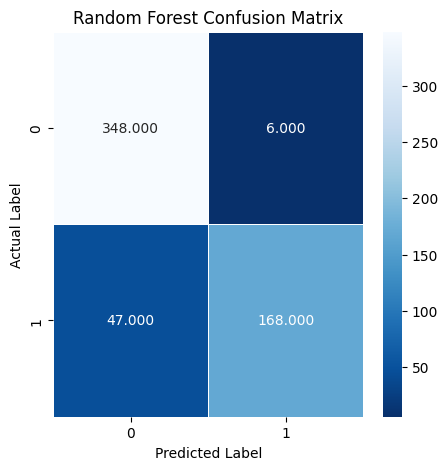

In [51]:
# We use the confusion matrix to visualize the performance of our classifier.
# It helps us understand how well the model distinguishes between the classes,
# showing the number of correct and incorrect predictions for each class.
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt=".3f", linewidths=0.5, cmap="Blues_r")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Random Forest Confusion Matrix")

In [52]:
# Classification report for further insights
# We can see it differs from our best model, slightly better at recall and slightly worse
# at precision for example
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       354
           1       0.97      0.78      0.86       215

    accuracy                           0.91       569
   macro avg       0.92      0.88      0.90       569
weighted avg       0.91      0.91      0.90       569

